### Advanced Machine Learning

# Home Exercise #2

Assignment Due: 18/04/21 23:59

Jonathan Schler

In [65]:
student1Name="Alexander Kruglyak" # student1 name here
student1ID="323637736" # student1 ID here


student2Name="Sofya Zubtsovsky" # student2 name here
student2ID="337839112" # student2 ID here


The goal of this homework is to provide a realistic setting for a machine learning task. Therefore instructions will not specify the exact steps to carry out. Instead, it is part of theassignment to identify promising features, models and preprocessing methods and apply themas appropriate.

The overall goal is to predict whether a specific credit card transaction is fraudulent or not. Please use the data from this dataset provided on Kaggle here:https://www.kaggle.com/kartik2112/fraud-detection. The Kaggle page also contains a description of the dataset. You will use the train set for training the model and test set for validation.

You are free to manipulate the train dataset as you think is appropriate. You do not have to use the wholedataset, you can subsample if you want. While the modelling process is likely iterative, please lay out the  following tasks in the given order to facilitate grading.

In [245]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import re
import datetime

from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import make_pipeline, Pipeline

from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon


%matplotlib inline

In [67]:
COLUMNS_TO_DROP = [
#     "Unnamed: 0",
#     "trans_num",
#     "trans_date_trans_time", # TODO: we need to split it to bins of day
    
#     "first", "last", # TODO: we can think to identify nationality by name
] 

def get_continuous_features(df):
    return df.select_dtypes(exclude=['object'])

def get_categorical_features(df):
    return df.select_dtypes(include=['object'])

def read_test_data():
    return drop_columns(read_data("fraudTest.csv"), COLUMNS_TO_DROP)

def read_data(file_name):
    return pd.read_csv(file_name)

def drop_columns(df, columns):
    return df.copy().drop(columns, axis=1)

In [68]:
features_description = {
}

title_font = {
        'color':  'darkblue',
        'weight': 'normal',
        'size': 20,
        }
labels_font = {
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }

In [69]:
#### trans_date_trans_time to trans_date_category ####

def get_hour_as_category(hour):
        day_time_category = "night"
        
        if 6 <= hour and hour < 12: 
            day_time_category = "morning"
        elif hour >=12 and hour < 18:
            day_time_category = "afternoon"
        elif hour >= 18 and hour < 22:
            day_time_category = "evening"
            
        return day_time_category

def convert_to_categorical_trans_date(df):
    _df = df.copy()
    trans_date_category_list = []
    
    for  i, d in enumerate(get_categorical_features(_df).trans_date_trans_time):
        day_of_week = datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S').strftime('%A');
        hour = datetime.datetime.strptime(d, '%Y-%m-%d %H:%M:%S').hour
        trans_date_category = "{}_{}".format(day_of_week, hour)
        trans_date_category_list.append(trans_date_category)
    
    _df['trans_date_category'] = trans_date_category_list
    return _df

def convert_to_categorical_trans_date_and_drop(df):
    converted_df = convert_to_categorical_trans_date(df)
    return drop_columns(converted_df, ["trans_date_trans_time"])

In [70]:
#### city_pop to city_pop_category ####

def population_as_category(p):
    category = "2M+"
    
    if p <= 100:
        category = "100-"
    elif p <= 500:
        category = "500-"
    elif p <= 1000:
        category = "1K-"
    elif p <= 2000:
        category = "2K-"
    elif p <= 3000:
        category = "3K-"
    elif p <= 5000:
        category = "5K-"
    elif p <= 10000:
        category = "10K-"
    elif p <= 30000:
        category = "30K-"
    elif p <= 50000:
        category = "50K-"
    elif p <= 100000:
        category = "100K-"
    elif p <= 200000:
        category = "200K-"
    elif p <= 500000:
        category = "500K-"
    elif p <= 1000000:
        category = "1M-"
    elif p <= 1500000:
        category = "1.5M-"
    elif p <= 2000000:
        category = "2M-"
        
    return category

def convert_to_categorical_city_pop(df):
    _df = df.copy()
    city_pop_category_list = []
    
    for p in df.city_pop:
        category = population_as_category(p)
        city_pop_category_list.append(category)
        
    _df['city_pop_category'] = city_pop_category_list
    return _df

In [131]:
def convert_cc_to_cc_type_and_drop(df):
    _df = convert_cc_to_cc_type(df)
    return drop_columns(_df, ["cc_num"])

def convert_cc_to_cc_type(df):
    _df = df.copy()
    cc_category_list = []
    
    for cc in df.cc_num:
        cc_category_list.append(get_cc_type(cc))
        
    _df['cc_type'] = cc_category_list
    return _df

def get_cc_type(cc_number):
    cc_number = str(cc_number)
    if is_american_express(cc_number): return 'AMEX'
    if is_visa(cc_number): return 'VISA'
    if is_mastercard(cc_number): return 'MasterCard'
    if is_discover(cc_number): return 'Discover'
    if is_jcb(cc_number): return 'JCB'
    if is_diners_club(cc_number): return 'DinersClub'
    if is_laser(cc_number): return 'Laser'
    if is_maestro(cc_number): return 'Maestro'
    if is_visa_electron(cc_number): return 'VisaElectron'
    if is_total_rewards_visa(cc_number): return 'TotalRewardsVisa'
    if is_diners_club_carte_blanche(cc_number): return 'DinersClubCarteBlanche'
    if is_diners_club_carte_international(cc_number): return 'DinersClubCarteInt'
    
    return 'unknown'

def is_american_express(cc_number):
    """Checks if the card is an american express. If us billing address country code, & is_amex, use vpos
    https://en.wikipedia.org/wiki/Bank_card_number#cite_note-GenCardFeatures-3
    :param cc_number: unicode card number
    """
    return bool(re.match(r'^3[47][0-9]{13}$', cc_number))


def is_visa(cc_number):
    """Checks if the card is a visa, begins with 4 and 12 or 15 additional digits.
    :param cc_number: unicode card number
    """

    # Standard Visa is 13 or 16, debit can be 19
    if bool(re.match(r'^4', cc_number)) and len(cc_number) in [13, 16, 19]:
        return True

    return False


def is_mastercard(cc_number):
    """Checks if the card is a mastercard. Begins with 51-55 or 2221-2720 and 16 in length.
    :param cc_number: unicode card number
    """
    if len(cc_number) == 16 and cc_number.isdigit():  # Check digit, before cast to int
        return bool(re.match(r'^5[1-5]', cc_number)) or int(cc_number[:4]) in range(2221, 2721)
    return False


def is_discover(cc_number):
    """Checks if the card is discover, re would be too hard to maintain. Not a supported card.
    :param cc_number: unicode card number
    """
    if len(cc_number) == 16:
        try:
            # return bool(cc_number[:4] == '6011' or cc_number[:2] == '65' or cc_number[:6] in range(622126, 622926))
            return bool(cc_number[:4] == '6011' or cc_number[:2] == '65' or 622126 <= int(cc_number[:6]) <= 622925)
        except ValueError:
            return False
    return False


def is_jcb(cc_number):
    """Checks if the card is a jcb. Not a supported card.
    :param cc_number: unicode card number
    """
    # return bool(re.match(r'^(?:2131|1800|35\d{3})\d{11}$', cc_number))  # wikipedia
    return bool(re.match(r'^35(2[89]|[3-8][0-9])[0-9]{12}$', cc_number))  # PawelDecowski


def is_diners_club(cc_number):
    """Checks if the card is a diners club. Not a supported card.
    :param cc_number: unicode card number
    """
    return bool(re.match(r'^3(?:0[0-6]|[68][0-9])[0-9]{11}$', cc_number))  # 0-5 = carte blance, 6 = international


def is_laser(cc_number):
    """Checks if the card is laser. Not a supported card.
    :param cc_number: unicode card number
    """
    return bool(re.match(r'^(6304|670[69]|6771)', cc_number))


def is_maestro(cc_number):
    """Checks if the card is maestro. Not a supported card.
    :param cc_number: unicode card number
    """
    possible_lengths = [12, 13, 14, 15, 16, 17, 18, 19]
    return bool(re.match(r'^(50|5[6-9]|6[0-9])', cc_number)) and len(cc_number) in possible_lengths


# Child cards

def is_visa_electron(cc_number):
    """Child of visa. Checks if the card is a visa electron. Not a supported card.
    :param cc_number: unicode card number
    """
    return bool(re.match(r'^(4026|417500|4508|4844|491(3|7))', cc_number)) and len(cc_number) == 16


def is_total_rewards_visa(cc_number):
    """Child of visa. Checks if the card is a Total Rewards Visa. Not a supported card.
    :param cc_number: unicode card number
    """
    return bool(re.match(r'^41277777[0-9]{8}$', cc_number))


def is_diners_club_carte_blanche(cc_number):
    """Child card of diners. Checks if the card is a diners club carte blance. Not a supported card.
    :param cc_number: unicode card number
    """
    return bool(re.match(r'^30[0-5][0-9]{11}$', cc_number))  # github PawelDecowski, jquery-creditcardvalidator


def is_diners_club_carte_international(cc_number):
    """Child card of diners. Checks if the card is a diners club international. Not a supported card.
    :param cc_number: unicode card number
    """
    return bool(re.match(r'^36[0-9]{12}$', cc_number))  # jquery-creditcardvalidator

In [72]:
convert_cc_to_cc_type(df_test).cc_type.value_counts()
df_test
# convert_to_categorical_trans_date_and_drop(df_test).columns

In [155]:
def unite_state_city(df):
    _df = df.copy()
    state_city_list = []
    
    for index, row in _df.iterrows():
        state_city = row['state'] + "_" + row['city']
        state_city_list.append(state_city)
        
    _df['city'] = state_city_list
    return _df

## Task 1 Identify Features
Assemble a dataset consisting of features and target (for example in a dataframe or in two arrays X and y). What features are relevant for the prediction task? What features should be excluded because they leak the target information? Show visualizations or statistics to support your selection

In [234]:
data = drop_columns(read_data("fraudTest.csv"), ["Unnamed: 0"])
data = convert_cc_to_cc_type_and_drop(data)
data = unite_state_city(data)

In [235]:
fraud = data[data['is_fraud']==1]
normal = data[data['is_fraud']==0]

In [157]:
data

,trans_date_trans_time,merchant,category,amt,first,last,gender,street,city,state,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,cc_type
0,2020-06-21 12:14:25,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,SC_Columbia,SC,...,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0,MasterCard
1,2020-06-21 12:14:33,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,UT_Altonah,UT,...,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0,JCB
2,2020-06-21 12:14:53,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,NY_Bellmore,NY,...,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0,unknown
3,2020-06-21 12:15:15,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,FL_Titusville,FL,...,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0,unknown
4,2020-06-21 12:15:17,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,MI_Falmouth,MI,...,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
555714,2020-12-31 23:59:07,fraud_Reilly and Sons,health_fitness,43.77,Michael,Olson,M,558 Michael Estates,MO_Luray,MO,...,-91.8912,519,Town planner,1966-02-13,9b1f753c79894c9f4b71f04581835ada,1388534347,39.946837,-91.333331,0,DinersClub
555715,2020-12-31 23:59:09,fraud_Hoppe-Parisian,kids_pets,111.84,Jose,Vasquez,M,572 Davis Mountains,TX_Lake Jackson,TX,...,-95.4401,28739,Futures trader,1999-12-27,2090647dac2c89a1d86c514c427f5b91,1388534349,29.661049,-96.186633,0,JCB
555716,2020-12-31 23:59:15,fraud_Rau-Robel,kids_pets,86.88,Ann,Lawson,F,144 Evans Islands Apt. 683,WA_Burbank,WA,...,-118.9017,3684,Musician,1981-11-29,6c5b7c8add471975aa0fec023b2e8408,1388534355,46.658340,-119.715054,0,Discover
555717,2020-12-31 23:59:24,fraud_Breitenberg LLC,travel,7.99,Eric,Preston,M,7020 Doyle Stream Apt. 951,ID_Mesa,ID,...,-116.4493,129,Cartographer,1965-12-15,14392d723bb7737606b2700ac791b7aa,1388534364,44.470525,-117.080888,0,VISA


In [134]:
pd.concat([fraud.amt.describe(), normal.amt.describe()], keys=["fraud_amt", "non_fraud_amt"], axis=1)

,fraud_amt,non_fraud_amt
count,2145.000000,553574.000000
mean,528.356494,67.614408
std,392.747594,152.471931
min,1.780000,1.000000
25%,214.510000,9.600000
50%,371.940000,47.150000
75%,907.770000,82.620000
max,1320.920000,22768.110000


No handles with labels found to put in legend.
No handles with labels found to put in legend.


(0.0, 0.1)

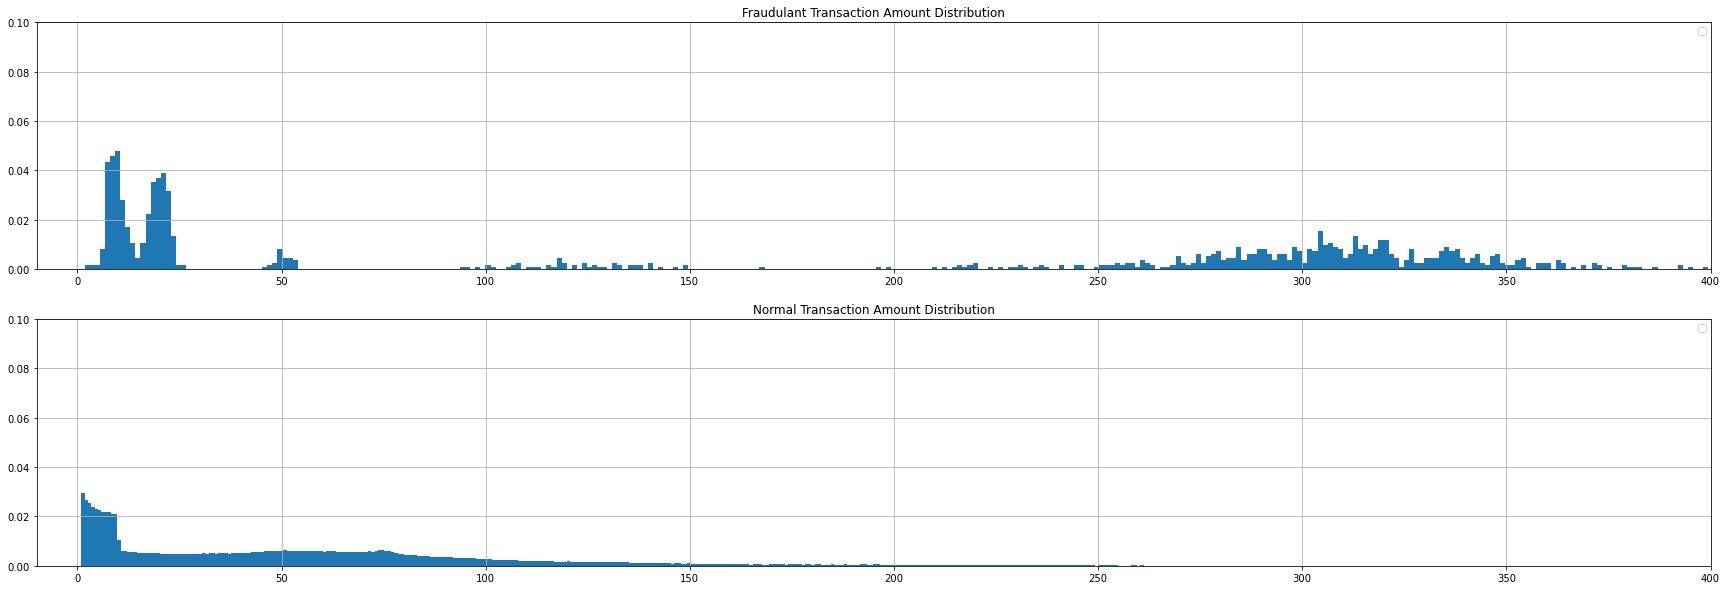

In [75]:
##### atm #####
plt.figure(figsize=(30, 10))

print()
plt.subplot(2, 1, 1)
subfraud = fraud[fraud.amt<500]
subfraud.amt.hist(bins=400,weights=np.ones(len(subfraud.amt)) / len(subfraud.amt))
plt.title("Fraudulant Transaction Amount Distribution")
plt.legend()
plt.xlim([-10,400])
plt.ylim([0,0.1])

plt.subplot(2, 1, 2)
subnormal = normal[normal.amt<400]
subnormal.amt.hist(bins=500, weights=np.ones(len(subnormal.amt)) / len(subnormal.amt))
plt.title("Normal Transaction Amount Distribution")
plt.legend()
plt.xlim([-10,400])
plt.ylim([0,0.1])

Conclusion:
We can see that transaction's amount is a good feature for fraud transaction recognition

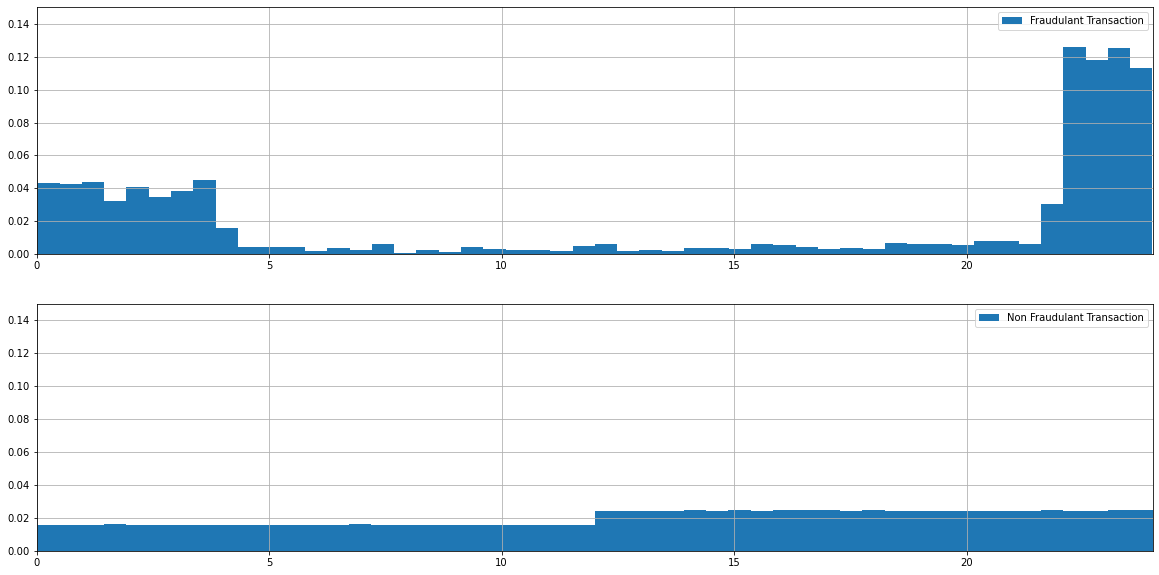

In [76]:
##### time #####

plt.figure(figsize=(20, 10))

plt.subplot(2, 1, 1)
fraud_24time = fraud.copy()
fraud_24time.unix_time = fraud_24time.unix_time % 86400 #(86400s per 24h)
fraud_24time.unix_time /= (86400/24)
fraud_24time.unix_time.hist(bins=50,label="Fraudulant Transaction",weights=np.ones(len(fraud_24time)) / len(fraud_24time))
plt.xlim([0,24])
plt.ylim([0,0.15])
plt.xlabel("")
plt.legend()

plt.subplot(2, 1, 2)
normal_24time = normal.copy()
normal_24time.unix_time  = normal_24time.unix_time  % 86400 #(86400s per 24h)
normal_24time.unix_time  /= (86400/24)
normal_24time.unix_time .hist(bins=50,label="Non Fraudulant Transaction",weights=np.ones(len(normal_24time)) / len(normal_24time))
plt.xlim([0,24])
plt.ylim([0,0.15])
plt.legend()

Conclusion:
We can see that transaction's time is a good feature for fraud transaction recognition

<AxesSubplot:>

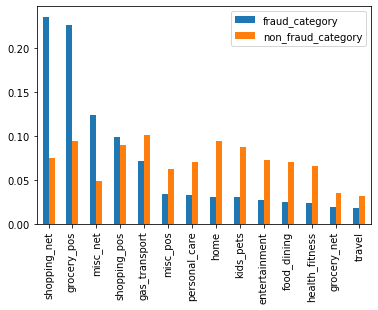

In [77]:
##### category #####
category_df = pd.concat([fraud.category.value_counts()/len(fraud.index), normal.category.value_counts()/len(normal.index)], keys=["fraud_category", "non_fraud_category"], axis=1)

category_df.plot(kind='bar')

Conclusion:
We can see that transaction category is a good feature for fraud recognition

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


<AxesSubplot:>

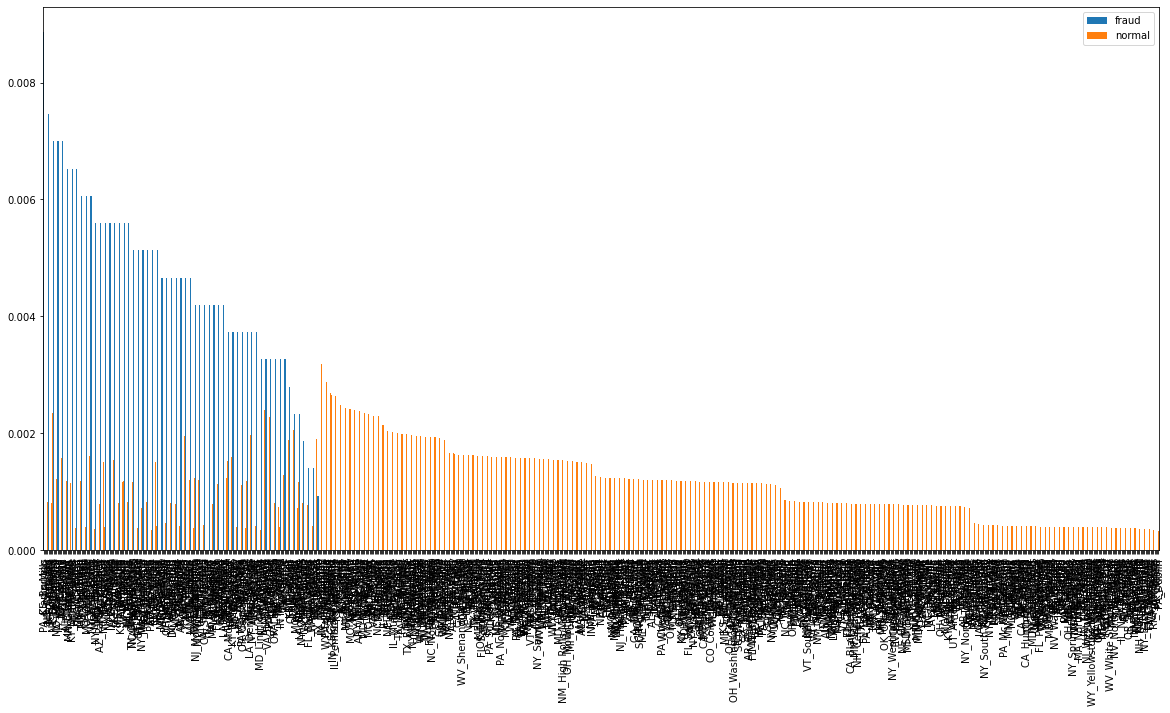

In [158]:
##### city #####
np.set_printoptions(suppress=True)
dropped = data.drop_duplicates(["city"], inplace=False)
total_pupulation = dropped.city_pop.sum()

dropped.city_pop = dropped.city_pop / total_pupulation
dropped.index  = dropped.city
dropped

city_df = pd.concat(
    [
        fraud.city.value_counts()/len(fraud.index), 
        normal.city.value_counts()/len(normal.index),
        # dropped.city_pop
    ], 
    # keys=["fraud", "normal", "normalized_pop"], 
    keys=["fraud", "normal"], 
    axis=1)

city_df

# /total_pupulation
# dropped.city_pop.value_counts()

# grouped = data.groupby('city')
# data.city.unique()
# data.loc['city', data.city.unique()]

# data.city_pop.sum()
fig, axes = plt.subplots(1, 1, figsize=(20,10))
city_df.plot(kind='bar',ax=axes)


<AxesSubplot:>

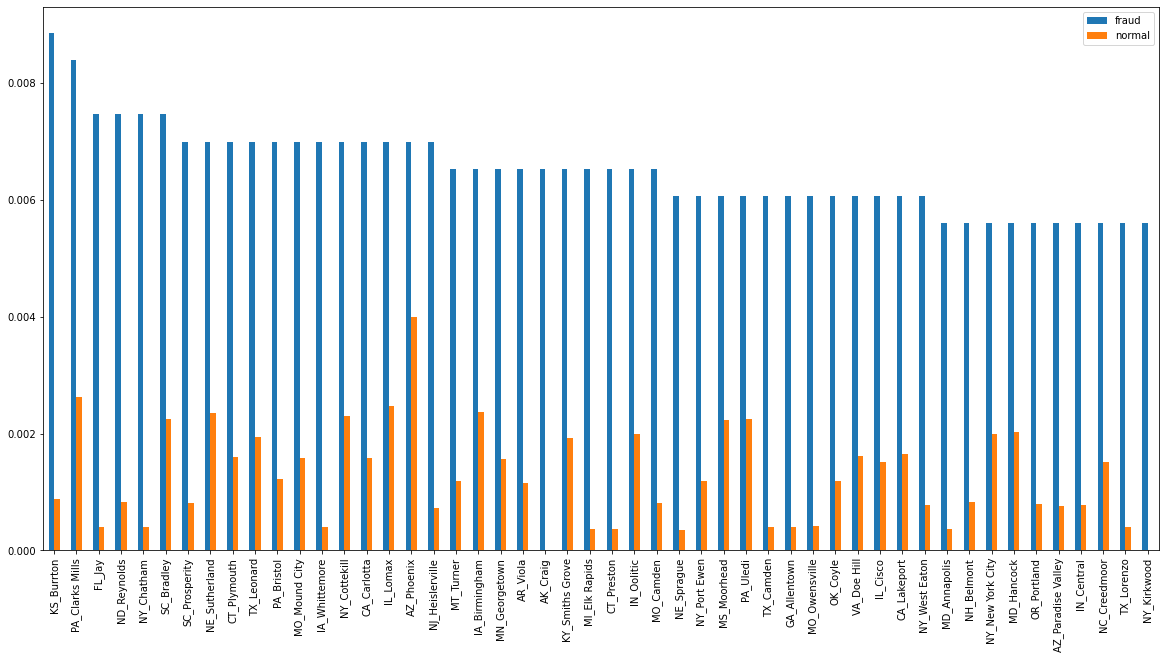

In [159]:
fig, axes = plt.subplots(1, 1, figsize=(20,10))
city_df[:50].plot(kind='bar',ax=axes)


In [212]:
city_df.index[0]
city_count = {}
for i in range(50):
    fraud_city = fraud[fraud['city']==city_df.index[i]]
    lat_unique = fraud_city.lat.nunique()
    long_unique = fraud_city.long.nunique()
    city_count[city_df.index[i]]= lat_unique > 1  or long_unique > 1

city_count

{'KS_Burrton': False,
 'PA_Clarks Mills': False,
 'FL_Jay': False,
 'ND_Reynolds': False,
 'NY_Chatham': False,
 'SC_Bradley': False,
 'SC_Prosperity': False,
 'NE_Sutherland': False,
 'CT_Plymouth': False,
 'TX_Leonard': False,
 'PA_Bristol': False,
 'MO_Mound City': False,
 'IA_Whittemore': False,
 'NY_Cottekill': False,
 'CA_Carlotta': False,
 'IL_Lomax': False,
 'AZ_Phoenix': False,
 'NJ_Heislerville': False,
 'MT_Turner': False,
 'IA_Birmingham': False,
 'MN_Georgetown': False,
 'AR_Viola': False,
 'AK_Craig': False,
 'KY_Smiths Grove': False,
 'MI_Elk Rapids': False,
 'CT_Preston': False,
 'IN_Oolitic': False,
 'MO_Camden': False,
 'NE_Sprague': False,
 'NY_Port Ewen': False,
 'MS_Moorhead': False,
 'PA_Uledi': False,
 'TX_Camden': False,
 'GA_Allentown': False,
 'MO_Owensville': False,
 'OK_Coyle': False,
 'VA_Doe Hill': False,
 'IL_Cisco': False,
 'CA_Lakeport': False,
 'NY_West Eaton': False,
 'MD_Annapolis': False,
 'NH_Belmont': False,
 'NY_New York City': False,
 'MD_Hancoc

We can see that location of card holder is not a good feature to recognize fraud.

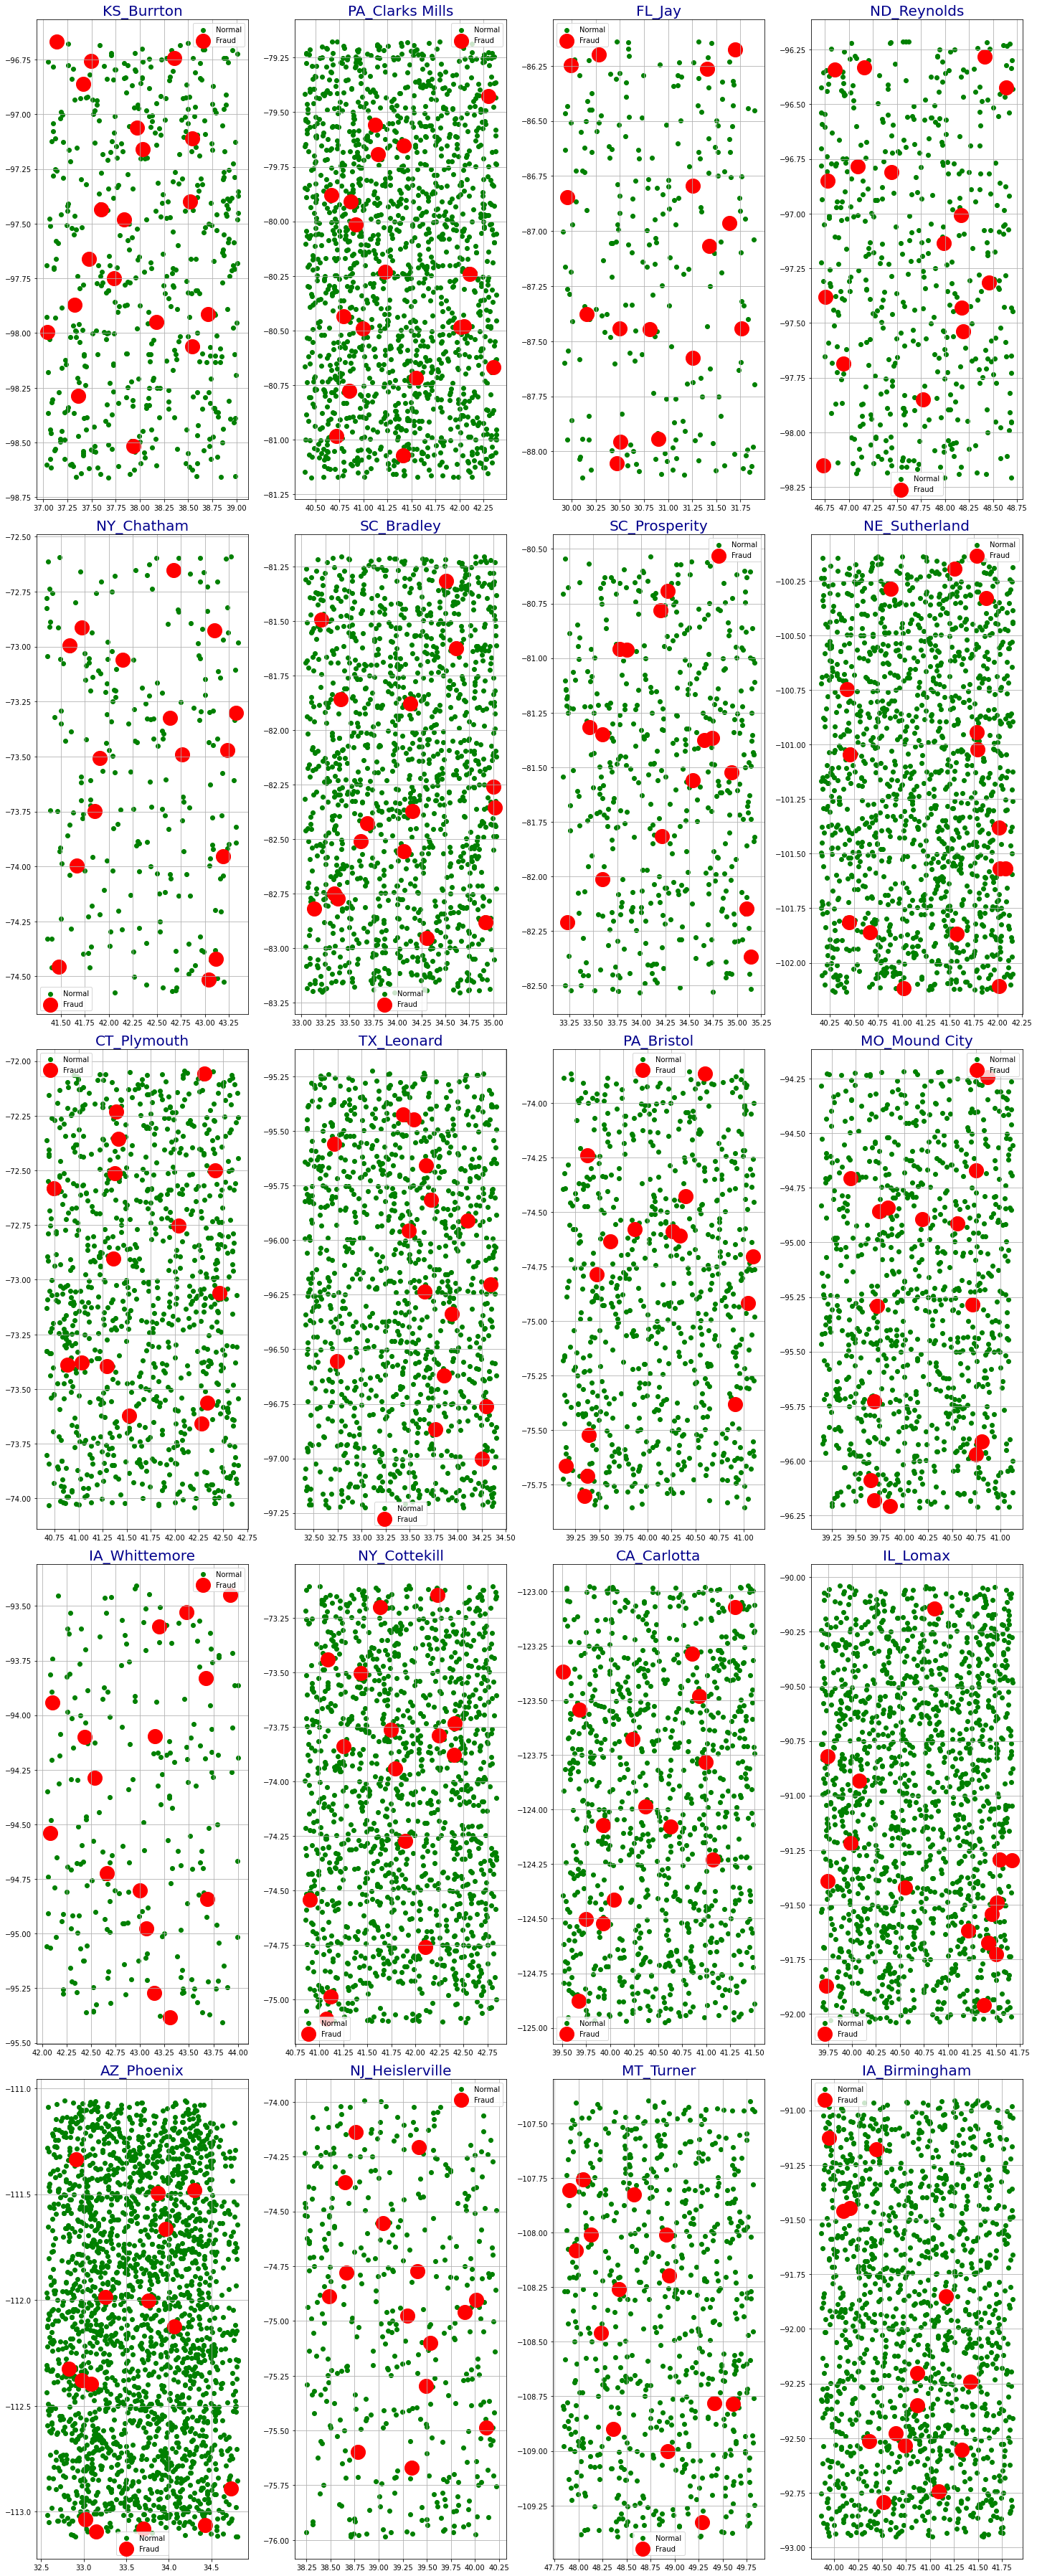

In [232]:
fig, axes = plt.subplots(5, 4, figsize=(20, 50))

for i, ax in enumerate(axes.ravel()):
    fraud_city =  fraud[fraud['city']==city_df.index[i]]
    normal_city =  normal[normal['city']==city_df.index[i]]
    ax.scatter(normal_city.merch_lat, normal_city.merch_long, label="Normal", alpha=1,color='green')
    ax.scatter(fraud_city.merch_lat, fraud_city.merch_long,label='Fraud', alpha=1, color='red',s=400)
    ax.legend()
    feature_name = city_df.index[i]
    ax.set_title("{}".format(feature_name), fontdict=title_font)
    ax.grid()
    
plt.tight_layout()


Above we plot the locations of merchant in the cities with the highest fraud density. As we can see, there is no pattern and merchan location is not a good feature to recognize the fraud. 

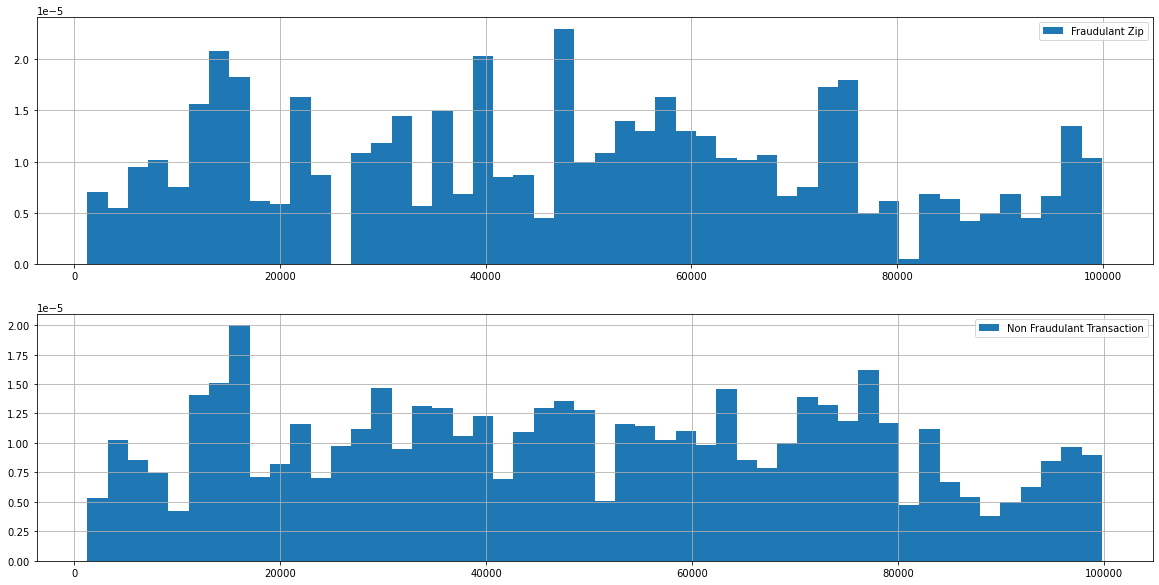

In [242]:
### zip code ### 
fraud.zip
plt.figure(figsize=(20, 10))
plt.subplot(2, 1, 1)
fraud.zip.hist(bins=50,label="Fraudulant Zip",density=True)
plt.legend()

plt.subplot(2, 1, 2)
normal.zip.hist(bins=50,label="Non Fraudulant Transaction",density=True)
plt.legend()

In [246]:
!pip install category_encoders

ERROR: Could not find a version that satisfies the requirement category_encoders (from versions: none)
ERROR: No matching distribution found for category_encoders


In [271]:
from category_encoders import TargetEncoder
label = data['is_fraud']
data_no_label = drop_columns(data,'is_fraud')
te = TargetEncoder(cols='zip',return_df=True).fit(data_no_label,label)
transformed = te.transform(data_no_label)
transformed['orig_zip'] = data['zip']
transformed['orig_zip']

C:\ProgramData\Anaconda3\lib\site-packages\category_encoders\utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


0         29209
1         84002
2         11710
3         32780
4         49632
          ...  
555714    63453
555715    77566
555716    99323
555717    83643
555718    73034
Name: orig_zip, Length: 555719, dtype: int64

In [263]:
fr_zip = data[data.zip == 422405]
fr_zip

,trans_date_trans_time,merchant,category,amt,first,last,gender,street,city,state,...,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud,cc_type


In [83]:
##### state #####
state_df = pd.concat(
    [
        fraud.state.value_counts()/len(fraud.index), 
        normal.state.value_counts()/len(normal.index),
    ], 
    keys=["fraud", "normal"], 
    axis=1)


<AxesSubplot:>

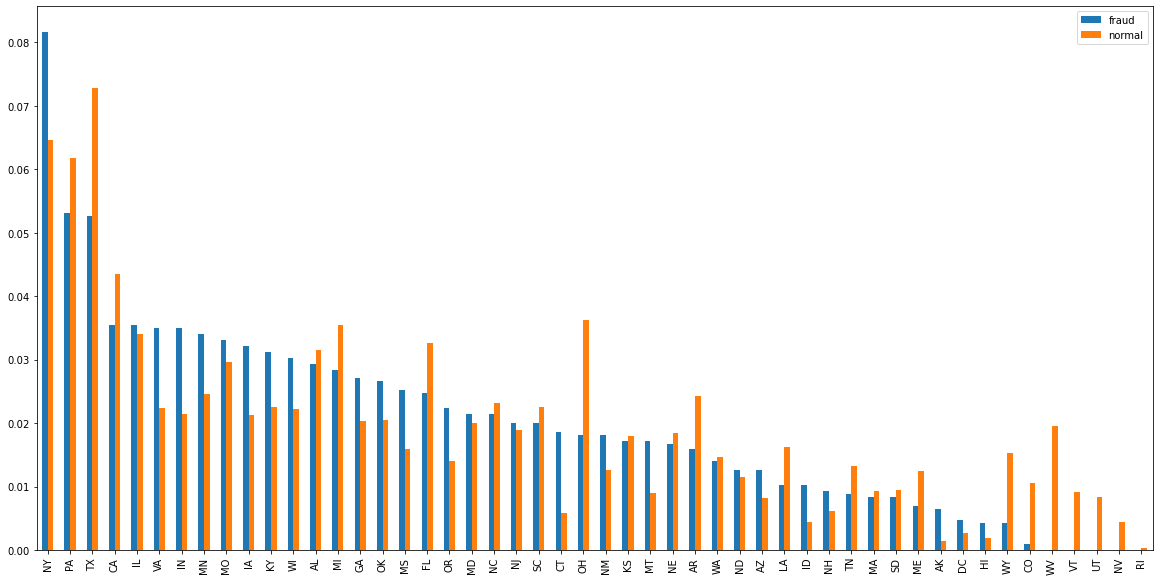

In [85]:
fig, axes = plt.subplots(1, 1, figsize=(20,10))

state_df.plot(kind='bar',ax=axes)

<AxesSubplot:>

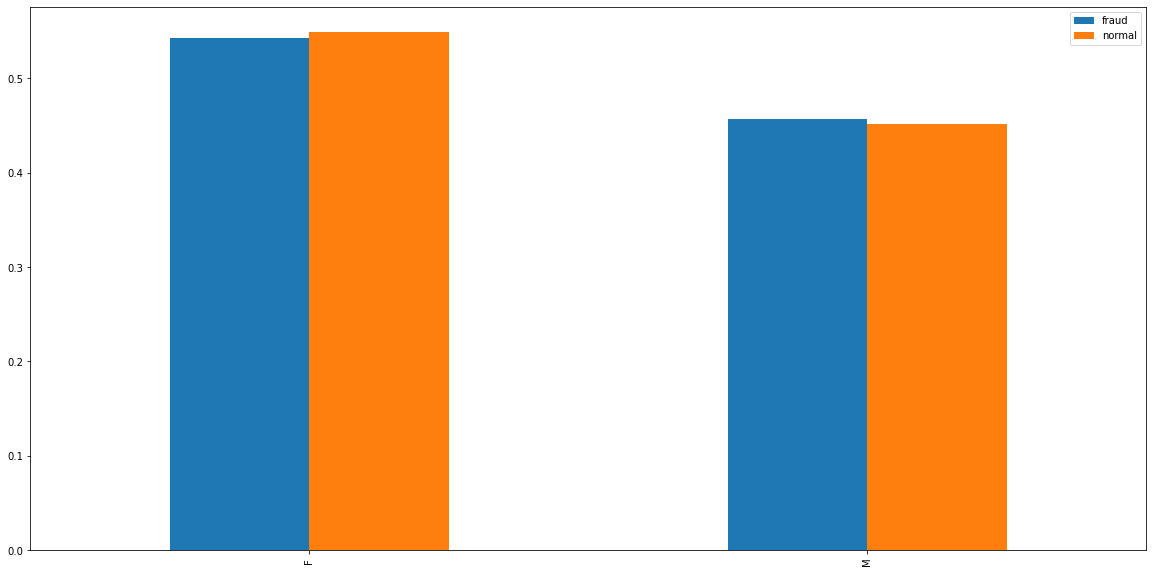

In [87]:
##### gender #####
gender_df = pd.concat(
    [
        fraud.gender.value_counts()/len(fraud.index), 
        normal.gender.value_counts()/len(normal.index),
    ], 
    keys=["fraud", "normal"], 
    axis=1)

fig, axes = plt.subplots(1, 1, figsize=(20,10))

gender_df.plot(kind='bar',ax=axes)

As we can see, gender is not significally vary between fraud and normal card holders.

<AxesSubplot:>

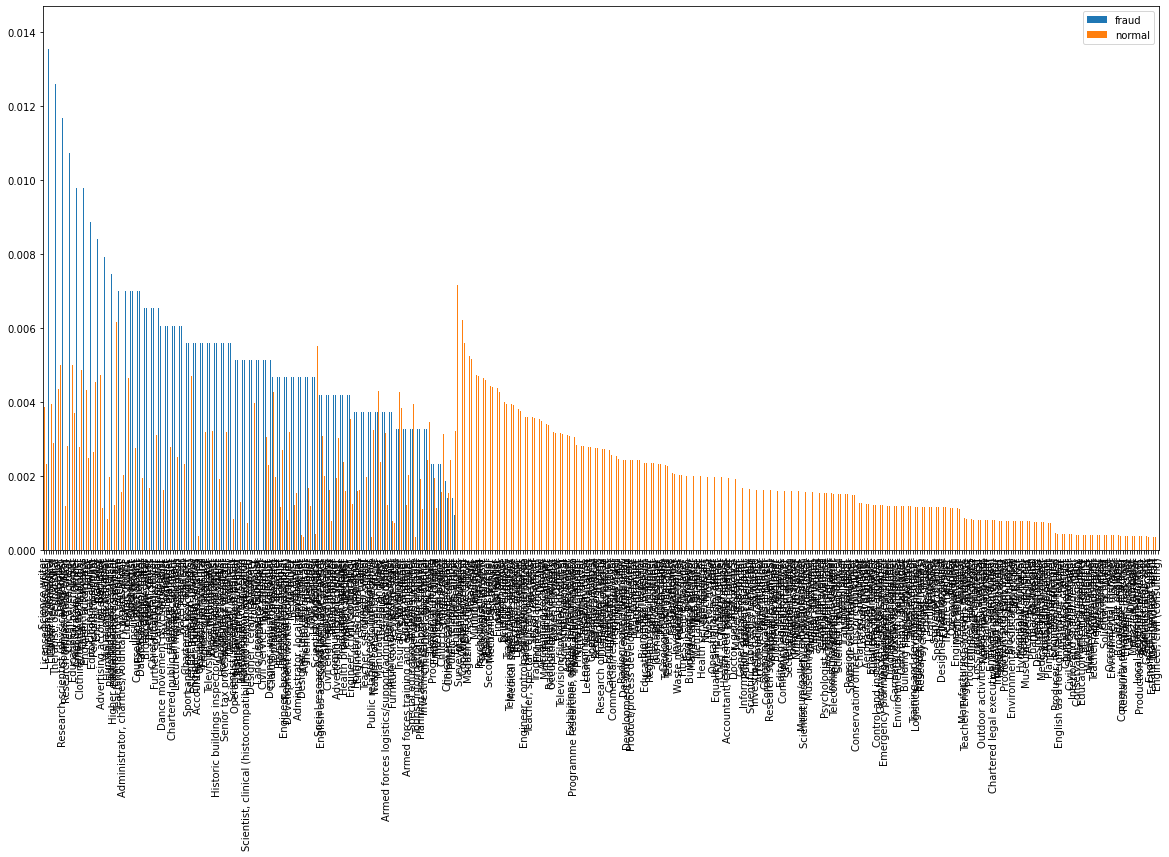

In [91]:
##### job #####
job_db = pd.concat(
    [
        fraud.job.value_counts()/len(fraud.index), 
        normal.job.value_counts()/len(normal.index),
    ], 
    keys=["fraud", "normal"], 
    axis=1)

fig, axes = plt.subplots(1, 1, figsize=(20,10))

job_db.plot(kind='bar',ax=axes)

Conclusion:
We can see that job is a good feature for fraud recognition

In [125]:
def haversine_distance(lat1, lon1, lat2, lon2):
    r = 6371
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2-lat1)
    delta_lambda = np.radians(lon2-lon1)
    a = np.sin(delta_phi / 2)**2 + np.cos(phi1) * np.cos(phi2) *   np.sin(delta_lambda / 2)**2
    res = r * (2 * np.arctan2(np.sqrt(a), np.sqrt(1-a)))
    return np.round(res, 2)

def calculate_holder_merch_distance(df):
    _df = df.copy()
    dist_list = []
    
    for index, row in df.iterrows():
        dist = haversine_distance(row['lat'],row['long'],row['merch_lat'],row['merch_long'])
        dist_list.append(dist)
    _df['holder_merch_dist'] = dist_list
    return _df

In [126]:
### location ### 

fraud  = calculate_holder_merch_distance(fraud)
normal = calculate_holder_merch_distance(normal)

<AxesSubplot:>

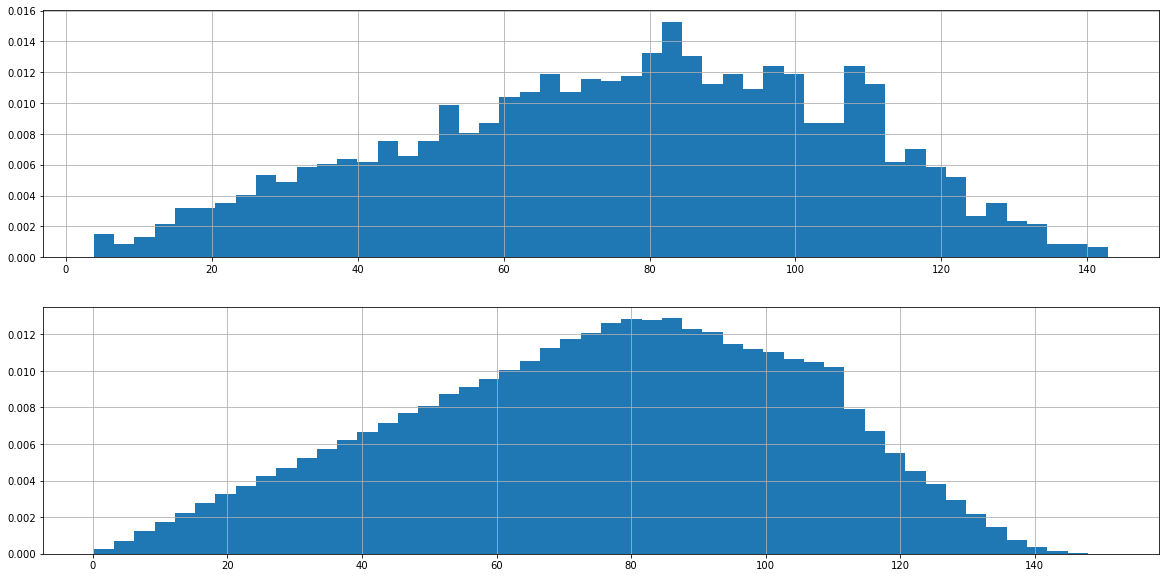

In [127]:
plt.figure(figsize=(20, 10))

plt.subplot(2, 1, 1)
fraud.holder_merch_dist.hist(bins=50,label="Fraudulant Distance",density=True)

plt.subplot(2, 1, 2)
normal.holder_merch_dist.hist(bins=50,label="Non Fraudulant Distance",density=True)

Conclusion:
We can see that distance between card holder location and merchant location is not a good feature for fraud recognition

<AxesSubplot:>

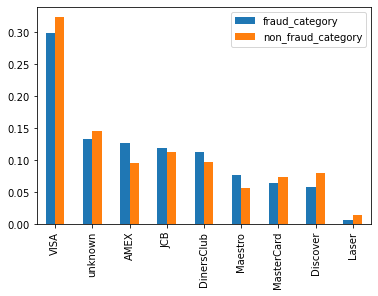

In [135]:
##### card type #####
card_type_df = pd.concat([fraud.cc_type.value_counts()/len(fraud.index), normal.cc_type.value_counts()/len(normal.index)], keys=["fraud_category", "non_fraud_category"], axis=1)

card_type_df.plot(kind='bar')

Conclusion:
We can see that card type is not a good feature for fraud recognition

<AxesSubplot:title={'center':'Correlation of Numeric Features'}>

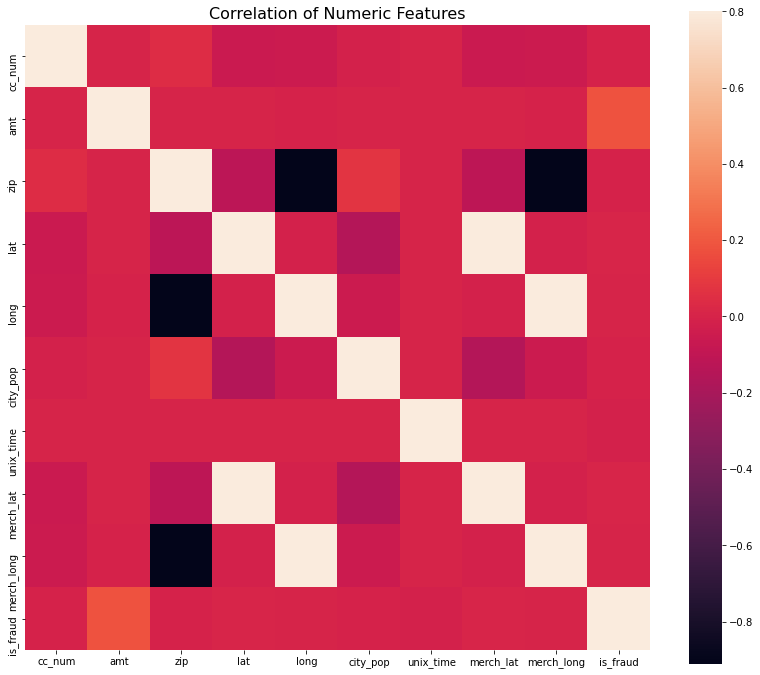

In [117]:
plt.subplots(figsize = (14,12))
plt.title('Correlation of Numeric Features',y=1,size=16)
sns.heatmap(data.corr(),square = True,  vmax=0.8)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


(0.0, 0.1)

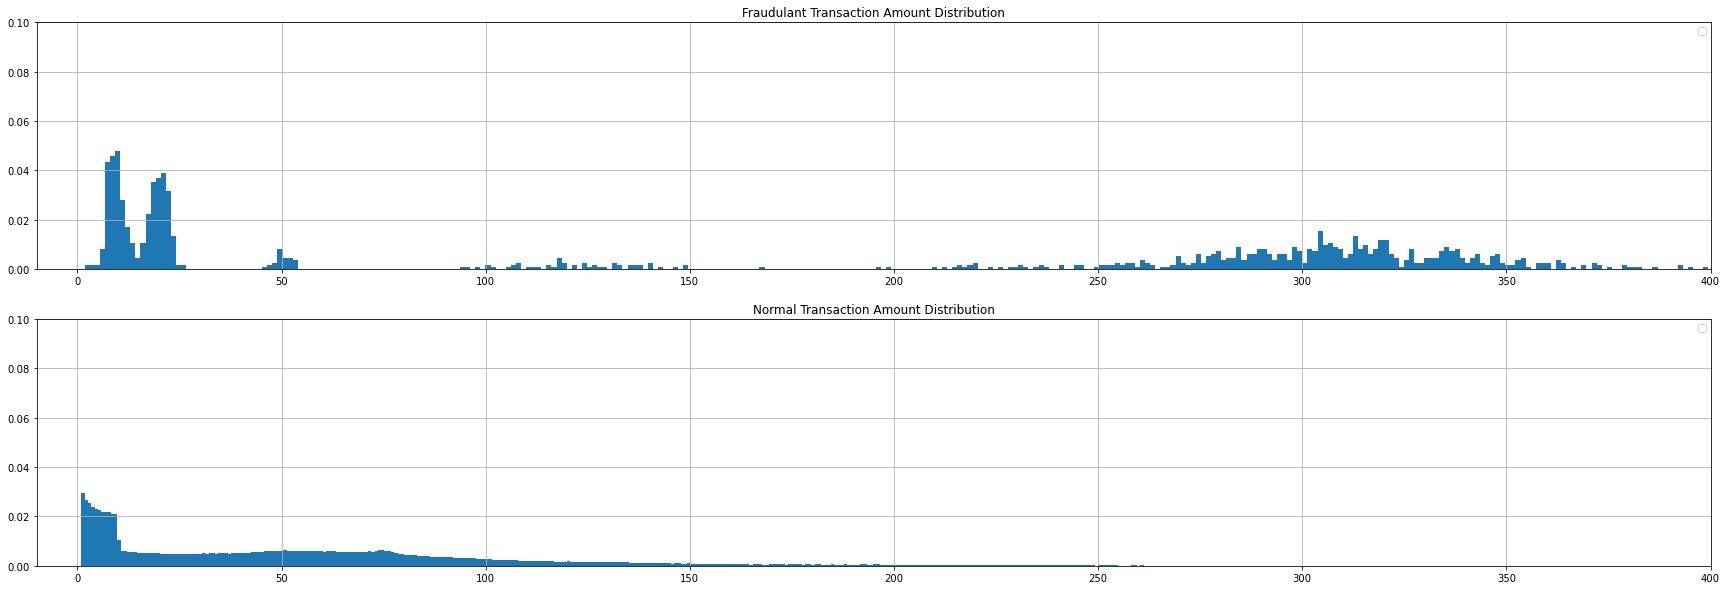

In [100]:
plt.figure(figsize=(30, 10))

print()
plt.subplot(2, 1, 1)
subfraud = fraud[fraud.amt<500]
subfraud.amt.hist(bins=400,weights=np.ones(len(subfraud.amt)) / len(subfraud.amt))
plt.title("Fraudulant Transaction Amount Distribution")
plt.legend()
plt.xlim([-10,400])
plt.ylim([0,0.1])

plt.subplot(2, 1, 2)
subnormal = normal[normal.amt<400]
subnormal.amt.hist(bins=500, weights=np.ones(len(subnormal.amt)) / len(subnormal.amt))
plt.title("Normal Transaction Amount Distribution")
plt.legend()
plt.xlim([-10,400])
plt.ylim([0,0.1])

In [98]:
df_test = read_test_data()
df_test = convert_to_categorical_trans_date_and_drop(df_test)
# get_categorical_features(df_test).columns

df_test.amt.describe()

count    555719.000000
mean         69.392810
std         156.745941
min           1.000000
25%           9.630000
50%          47.290000
75%          83.010000
max       22768.110000
Name: amt, dtype: float64

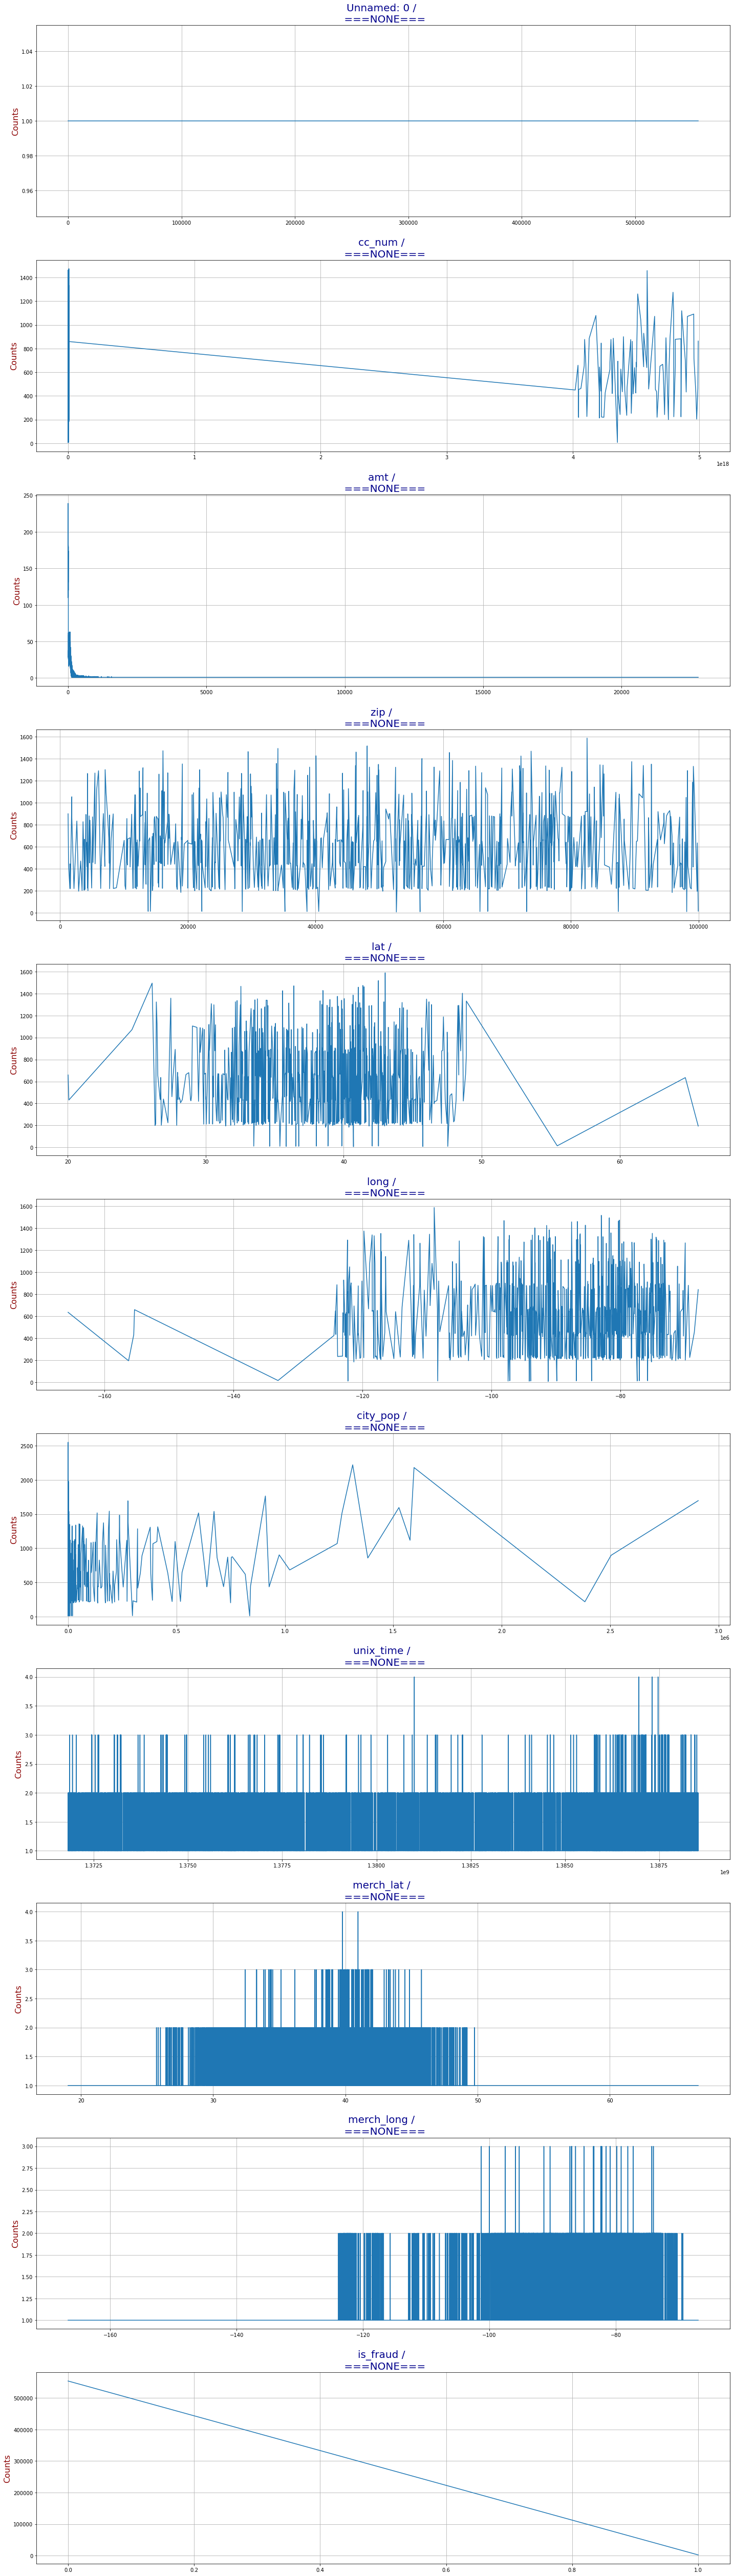

In [87]:
fig, axes = plt.subplots(11, 1, figsize=(20, 70))
continuous_features = get_continuous_features(df_test)

for i, ax in enumerate(axes.ravel()):
    feature_name = continuous_features.columns[i]
    feature_human_readable_name = features_description.get(feature_name, "===NONE===")
    y = continuous_features[feature_name].value_counts().sort_index()
    ax.set_title("{} / \n {}".format(feature_name, feature_human_readable_name), fontdict=title_font)
    ax.set_ylabel("Counts", fontdict=labels_font)
    ax.plot(y)
    ax.grid()
plt.tight_layout()

IndexError: single positional indexer is out-of-bounds

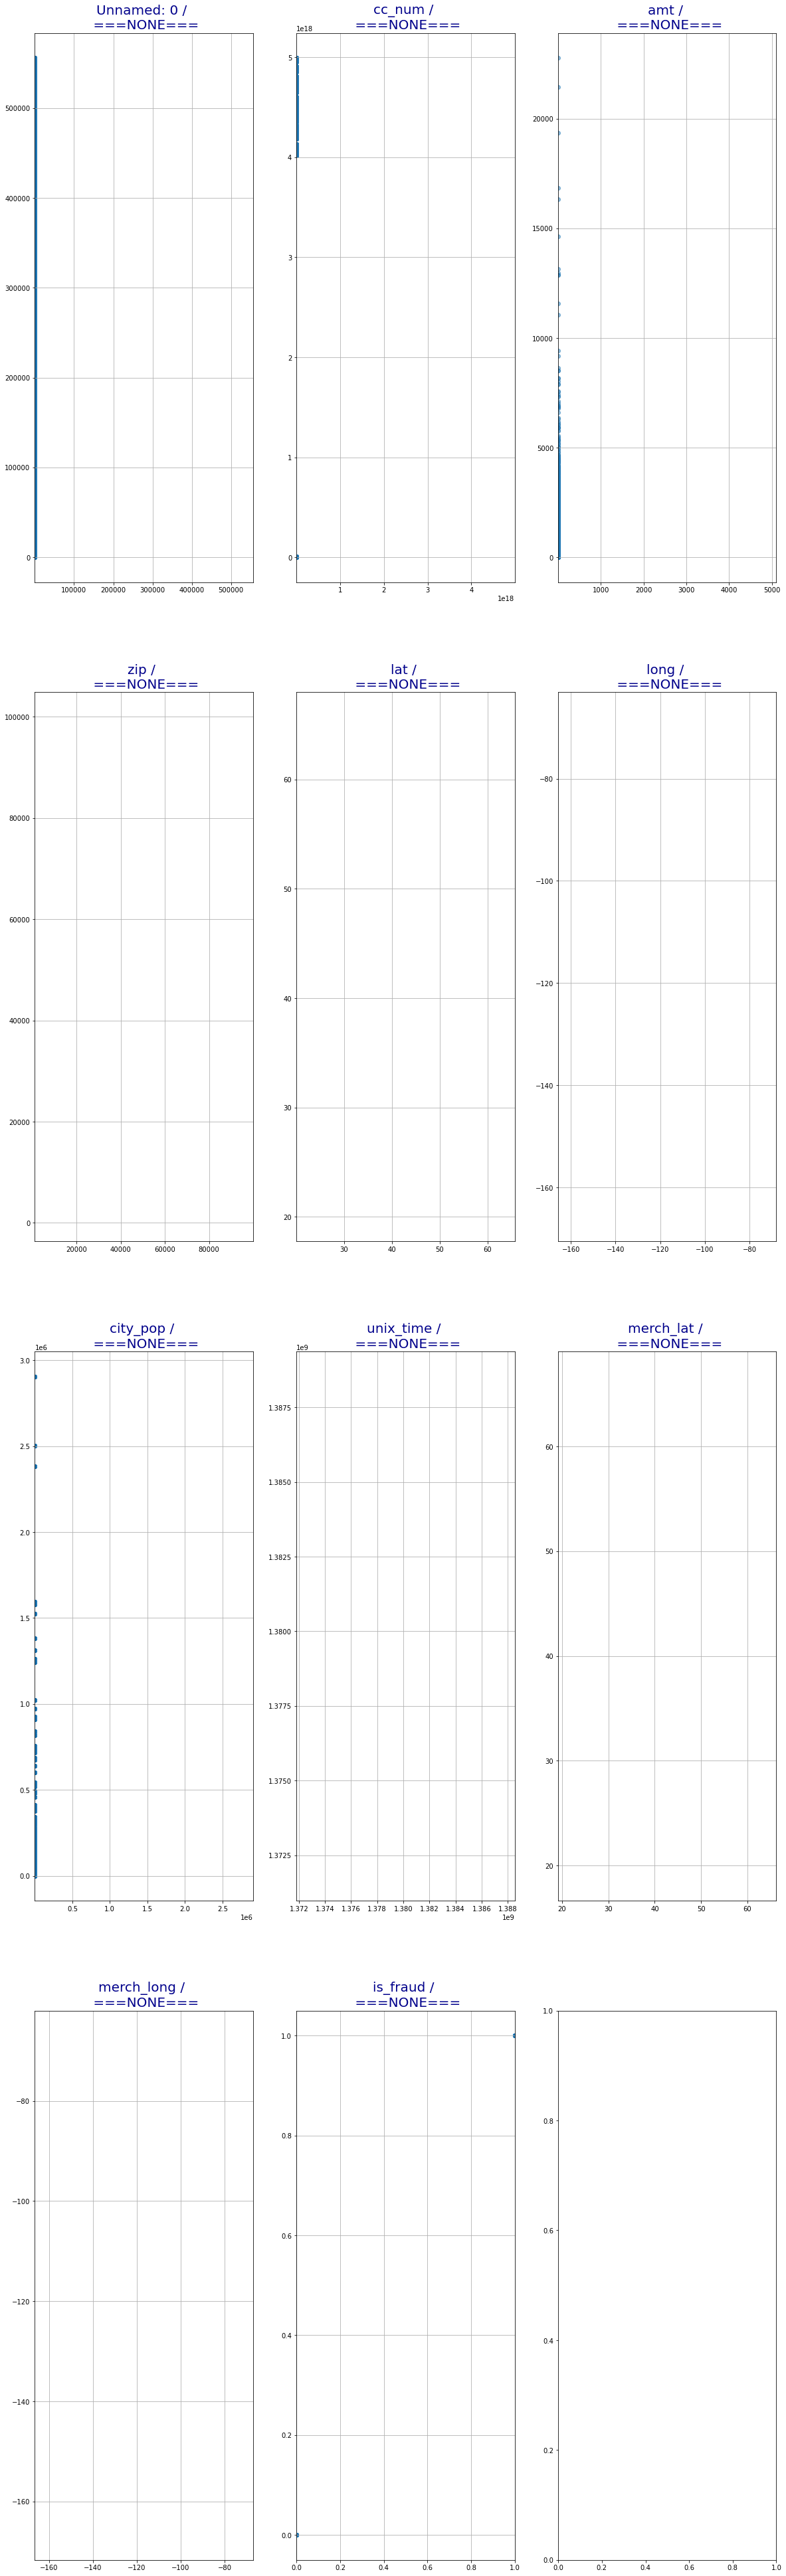

In [97]:
fig, axes = plt.subplots(4, 3, figsize=(20, 70))
x = df_test.is_fraud

for i, ax in enumerate(axes.ravel()):
    X_col = continuous_features.iloc[:, i]
#     ax.set_xlim(0, 1)
    ax.set_xlim(right=1)
    if X_col.nunique() > 10:
        ax.set_xlim(X_col.quantile(q=.0001), X_col.quantile(q=.9999))
        
    ax.scatter(x, X_col, alpha=.5)

    feature_name = continuous_features.columns[i]
    feature_human_readable_name = features_description.get(feature_name, "===NONE===")
    ax.set_title("{} / \n {}".format(feature_name, feature_human_readable_name), fontdict=title_font)
#     ax.set_ylabel("Price ($)", fontdict=labels_font)
    ax.grid()
    
plt.tight_layout()

In [ ]:
categorical_features = get_categorical_features(df_test)


fig, axes = plt.subplots(3, 3, figsize=(30,60))
for i, ax in enumerate(axes.ravel()):
    if(i >= len(categorical_features.columns)):
        break
    categorical_features.iloc[:,i].value_counts().plot(kind='bar',ax=ax,rot=45)
    ax.set_title(categorical_features.columns[i])

## Task 2 Preprocessing and Baseline Model

Create a simple minimum viable model by doing an initial selection of features, doing appropriate preprocessing and cross-validating a linear model. Feel free to generously exclude features or do simplified preprocessing for this task. As mentioned before, you don’t need to validate the model on the whole dataset

## Task 3 Feature Engineering
Create derived features and perform more in-depth preprocessing and data cleaning. Does this improve your model? In particular, think about how to encode categorical variables.

## Task 4 Any model
Use any classification model we discussed (trees, forests, boosting, SVM) to improve your result. You can (and probably should) change your preprocessing and feature engineering to be suitable for the model. You are not required to try all of these models. Tune parameters as appropriate

## Task 5 Feature Selections
Identify features that are important for your best model. Which features are most influential,and which features could be removed without decrease in performance? Does removing irrelevant features make your model better?

## Task 6 An explainable model
Can you create an “explainable” model that is nearly as good as your best model? An explainable model should be small enough to be easily inspected - say a linear model withfew enough coefficients that you can reasonable look at all of them, or a tree with a smallnumber of leafs etc.